In [5]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [32]:
if os.path.exists('../data/processed/stocks/nse_scraped'):
    price_data = pd.read_csv('../data/processed/stocks/nse_scraped/TCS.csv')
else:
    price_data = pd.read_csv('../data/raw/stock/yahoo_finance/TCS')
price_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume
0,2004-08-25,TCS,EQ,850.0,1198.7,1198.7,979.0,985.0,987.95,1008.32,17116372
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.3,976.85,979.0,985.65,5055400
2,2004-08-27,TCS,EQ,979.0,982.4,982.4,958.55,961.2,962.65,969.94,3830750
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.0,986.4,986.75,982.65,3058151
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.0,987.8,988.1,982.18,2649332


In [7]:
price_data = price_data[['Date','Symbol','Prev Close','Open',
                         'High','Low','Last','Close','VWAP','Volume']]

# sort the values by symbol and then date
price_data.sort_values(by = ['Symbol','Date'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['Close'].diff()

In [8]:
# identify rows where the symbol changes
mask = price_data['Symbol'] != price_data['Symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,change_in_price
1023,2012-01-17,ADANIPORTS,135.5,137.1,141.0,135.0,140.1,140.0,138.13,1636196,NaN
0,2007-11-27,MUNDRAPORT,440.0,770.0,1050.0,770.0,959.0,962.9,984.72,27294366,NaN


In [9]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['Symbol'])[['Close','Low','High','Open','Volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['Symbol','Date']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,Symbol,Date,Close,Low,High,Open,Volume
1023,ADANIPORTS,2012-01-17,140.000000,135.000000,141.000000,137.100000,1.636196e+06
1024,ADANIPORTS,2012-01-18,140.878333,136.911667,142.446667,139.631667,1.250967e+06
1025,ADANIPORTS,2012-01-19,143.910292,139.131229,145.329785,141.185894,1.323944e+06
1026,ADANIPORTS,2012-01-20,147.076126,142.194856,148.710677,144.138021,1.409395e+06
1027,ADANIPORTS,2012-01-23,147.001924,142.855846,150.232660,146.700394,1.465870e+06
...,...,...,...,...,...,...,...
1018,MUNDRAPORT,2012-01-10,128.102974,124.811614,130.807004,128.137302,1.182316e+06
1019,MUNDRAPORT,2012-01-11,128.680201,125.452800,131.445262,128.644573,1.222860e+06
1020,MUNDRAPORT,2012-01-12,128.936317,125.823587,131.835890,129.215891,1.256791e+06
1021,MUNDRAPORT,2012-01-13,129.104942,126.064001,131.910994,129.427769,1.246657e+06


In [10]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('Symbol')['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,Symbol,Date,Close,Low,High,Open,Volume,Signal_Flag
1023,ADANIPORTS,2012-01-17,140.000000,135.000000,141.000000,137.100000,1.636196e+06,NaN
1024,ADANIPORTS,2012-01-18,140.878333,136.911667,142.446667,139.631667,1.250967e+06,NaN
1025,ADANIPORTS,2012-01-19,143.910292,139.131229,145.329785,141.185894,1.323944e+06,NaN
1026,ADANIPORTS,2012-01-20,147.076126,142.194856,148.710677,144.138021,1.409395e+06,NaN
1027,ADANIPORTS,2012-01-23,147.001924,142.855846,150.232660,146.700394,1.465870e+06,NaN
1028,ADANIPORTS,2012-01-24,147.598232,143.392697,150.754483,146.768789,1.440729e+06,NaN
1029,ADANIPORTS,2012-01-25,146.837529,143.195060,150.788299,147.491956,1.513178e+06,NaN
1030,ADANIPORTS,2012-01-27,146.878484,143.445488,150.610683,147.227950,1.474373e+06,NaN
1031,ADANIPORTS,2012-01-30,145.666460,142.574121,150.151707,147.209660,1.371922e+06,NaN
1032,ADANIPORTS,2012-01-31,145.743812,141.835239,149.932764,146.114795,1.361241e+06,NaN


In [11]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['Symbol','change_in_price']].copy(), price_data[['Symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,change_in_price,down_days,up_days,RSI
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,NaN,NaN,NaN,NaN
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,1.70,0.00,1.70,100.000000
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,7.70,0.00,7.70,100.000000
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,6.00,0.00,6.00,100.000000
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,-8.65,8.65,0.00,58.293541
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,3.30,0.00,3.30,64.762748
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,-6.85,6.85,0.00,47.219981
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,3.90,0.00,3.90,55.193278
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,-8.70,8.70,0.00,39.740558
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,7.85,0.00,7.85,53.340987


In [12]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['Symbol','Low']].copy(), price_data[['Symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,1.70,0.00,1.70,100.000000,NaN,NaN,NaN
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,7.70,0.00,7.70,100.000000,NaN,NaN,NaN
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,6.00,0.00,6.00,100.000000,NaN,NaN,NaN
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,-8.65,8.65,0.00,58.293541,NaN,NaN,NaN
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,3.30,0.00,3.30,64.762748,NaN,NaN,NaN
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,-6.85,6.85,0.00,47.219981,NaN,NaN,NaN
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,3.90,0.00,3.90,55.193278,NaN,NaN,NaN
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,-8.70,8.70,0.00,39.740558,NaN,NaN,NaN
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,7.85,0.00,7.85,53.340987,NaN,NaN,NaN


In [13]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['Symbol','Low']].copy(), price_data[['Symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,1.70,0.00,1.70,100.000000,NaN,NaN,NaN,NaN
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,7.70,0.00,7.70,100.000000,NaN,NaN,NaN,NaN
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,6.00,0.00,6.00,100.000000,NaN,NaN,NaN,NaN
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,-8.65,8.65,0.00,58.293541,NaN,NaN,NaN,NaN
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,3.30,0.00,3.30,64.762748,NaN,NaN,NaN,NaN
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,-6.85,6.85,0.00,47.219981,NaN,NaN,NaN,NaN
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,3.90,0.00,3.90,55.193278,NaN,NaN,NaN,NaN
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,-8.70,8.70,0.00,39.740558,NaN,NaN,NaN,NaN
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,7.85,0.00,7.85,53.340987,NaN,NaN,NaN,NaN


In [14]:
# Calculate the MACD
ema_26 = price_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,1.70,0.00,1.70,100.000000,NaN,NaN,NaN,NaN,0.038141,0.021189
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,7.70,0.00,7.70,100.000000,NaN,NaN,NaN,NaN,0.287376,0.130282
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,6.00,0.00,6.00,100.000000,NaN,NaN,NaN,NaN,0.610317,0.292896
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,-8.65,8.65,0.00,58.293541,NaN,NaN,NaN,NaN,0.428747,0.333308
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,3.30,0.00,3.30,64.762748,NaN,NaN,NaN,NaN,0.452650,0.365657
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,-6.85,6.85,0.00,47.219981,NaN,NaN,NaN,NaN,0.149865,0.311045
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,3.90,0.00,3.90,55.193278,NaN,NaN,NaN,NaN,0.129913,0.267516
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,-8.70,8.70,0.00,39.740558,NaN,NaN,NaN,NaN,-0.317520,0.132370
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,7.85,0.00,7.85,53.340987,NaN,NaN,NaN,NaN,-0.225948,0.052086


In [15]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('Symbol')['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,...,0.00,1.70,100.000000,NaN,NaN,NaN,NaN,0.038141,0.021189,NaN
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,...,0.00,7.70,100.000000,NaN,NaN,NaN,NaN,0.287376,0.130282,NaN
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,...,0.00,6.00,100.000000,NaN,NaN,NaN,NaN,0.610317,0.292896,NaN
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,...,8.65,0.00,58.293541,NaN,NaN,NaN,NaN,0.428747,0.333308,NaN
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,...,0.00,3.30,64.762748,NaN,NaN,NaN,NaN,0.452650,0.365657,NaN
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,...,6.85,0.00,47.219981,NaN,NaN,NaN,NaN,0.149865,0.311045,NaN
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,...,0.00,3.90,55.193278,NaN,NaN,NaN,NaN,0.129913,0.267516,NaN
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,...,8.70,0.00,39.740558,NaN,NaN,NaN,NaN,-0.317520,0.132370,NaN
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,...,0.00,7.85,53.340987,NaN,NaN,NaN,NaN,-0.225948,0.052086,0.044643


In [16]:
def obv(group):

    # Grab the volume and close column.
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('Symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)

,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
1023,2012-01-17,ADANIPORTS,135.50,137.10,141.00,135.00,140.10,140.00,138.13,1636196,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1024,2012-01-18,ADANIPORTS,140.00,142.00,143.80,138.70,143.00,141.70,141.25,890591,...,1.70,100.000000,NaN,NaN,NaN,NaN,0.038141,0.021189,NaN,890591
1025,2012-01-19,ADANIPORTS,141.70,144.00,150.55,143.15,149.50,149.40,146.72,1456077,...,7.70,100.000000,NaN,NaN,NaN,NaN,0.287376,0.130282,NaN,2346668
1026,2012-01-20,ADANIPORTS,149.40,151.90,157.60,150.25,155.40,155.40,153.76,1634070,...,6.00,100.000000,NaN,NaN,NaN,NaN,0.610317,0.292896,NaN,3980738
1027,2012-01-23,ADANIPORTS,155.40,155.40,155.40,145.10,146.40,146.75,149.54,1657609,...,0.00,58.293541,NaN,NaN,NaN,NaN,0.428747,0.333308,NaN,2323129
1028,2012-01-24,ADANIPORTS,146.75,147.05,152.90,145.60,149.80,150.05,150.29,1337362,...,3.30,64.762748,NaN,NaN,NaN,NaN,0.452650,0.365657,NaN,3660491
1029,2012-01-25,ADANIPORTS,150.05,150.95,150.95,142.25,144.35,143.20,144.80,1859617,...,0.00,47.219981,NaN,NaN,NaN,NaN,0.149865,0.311045,NaN,1800874
1030,2012-01-27,ADANIPORTS,143.20,145.80,149.65,144.80,146.75,147.10,147.69,1264483,...,3.90,55.193278,NaN,NaN,NaN,NaN,0.129913,0.267516,NaN,3065357
1031,2012-01-30,ADANIPORTS,147.10,147.10,147.40,137.35,138.40,138.40,142.13,757694,...,0.00,39.740558,NaN,NaN,NaN,NaN,-0.317520,0.132370,NaN,2307663
1032,2012-01-31,ADANIPORTS,138.40,138.95,148.50,137.00,147.10,146.25,143.17,1291344,...,7.85,53.340987,NaN,NaN,NaN,NaN,-0.225948,0.052086,0.044643,3599007


In [17]:
# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('Symbol')['Close']
# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))
price_data['Prediction'] = close_groups
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

In [18]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 3552 rows and 23 columns
After NaN Drop we have 3526 rows and 23 columns


,Date,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
1036,2012-02-06,ADANIPORTS,150.25,152.85,152.85,146.30,148.15,148.10,150.34,1518103,...,53.951317,135.0,157.6,57.964602,-42.035398,0.324604,0.115609,0.009199,2722959,-1.0
1037,2012-02-07,ADANIPORTS,148.10,149.15,149.45,137.85,137.85,139.15,142.49,1735290,...,39.886073,137.0,157.6,10.436893,-89.563107,-0.184165,0.053468,-0.072642,987669,-1.0
1038,2012-02-08,ADANIPORTS,139.15,139.00,143.30,136.60,140.00,140.30,140.87,1532614,...,42.123109,136.6,157.6,17.619048,-82.380952,-0.498153,-0.060051,-0.020251,2520283,1.0
1039,2012-02-09,ADANIPORTS,140.30,139.65,141.80,135.20,138.00,137.95,138.09,1907732,...,38.725216,135.2,157.6,12.276786,-87.723214,-0.876860,-0.227176,-0.062203,612551,-1.0
1040,2012-02-10,ADANIPORTS,137.95,138.15,144.15,137.20,142.95,142.90,140.28,1780060,...,48.769195,135.2,155.4,38.118812,-61.881188,-0.844026,-0.352810,0.032514,2392611,1.0


In [19]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent',
                     'Price_Rate_Of_Change','MACD',
                     'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [20]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.704255,0.762673,0.732301,434.000000
Up Day,0.750000,0.689732,0.718605,448.000000
accuracy,0.725624,0.725624,0.725624,0.725624
macro avg,0.727128,0.726202,0.725453,882.000000
weighted avg,0.727491,0.725624,0.725344,882.000000


Accuracy: 0.7256235827664399
Percision: 0.75
Recall: 0.6897321428571429
Specificity: 0.7626728110599078


/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


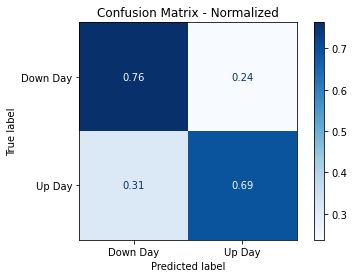

In [21]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [22]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.197732
k_percent               0.192748
RSI                     0.183938
Price_Rate_Of_Change    0.152083
MACD                    0.149359
On Balance Volume       0.124141
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

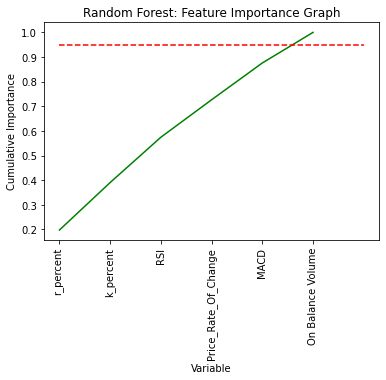

In [23]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


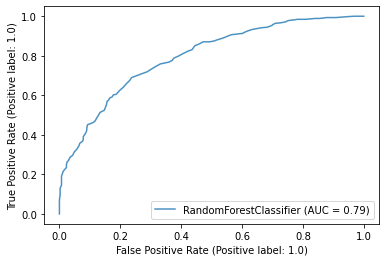

In [24]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

In [25]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.6947806354009077


In [26]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [27]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_estimators=400; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_estimators=400; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_est

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [28]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  74.94331065759637


,precision,recall,f1-score,support
Down Day,0.704255,0.762673,0.732301,434.000000
Up Day,0.750000,0.689732,0.718605,448.000000
accuracy,0.725624,0.725624,0.725624,0.725624
macro avg,0.727128,0.726202,0.725453,882.000000
weighted avg,0.727491,0.725624,0.725344,882.000000


r_percent               0.197732
k_percent               0.192748
RSI                     0.183938
Price_Rate_Of_Change    0.152083
MACD                    0.149359
On Balance Volume       0.124141
dtype: float64

/home/turner/miniconda3/envs/stock_prediction/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


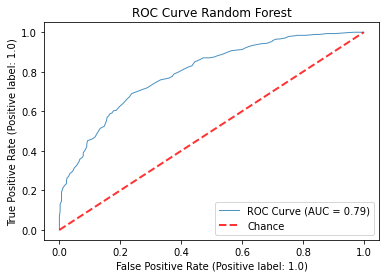

In [29]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

In [30]:
print(y_test)

1414    1.0
2261    1.0
1611    1.0
897     1.0
1503    1.0
       ... 
1134    1.0
865     1.0
655    -1.0
1076   -1.0
2422   -1.0
Name: Prediction, Length: 882, dtype: float64


In [31]:
print(X_test)

            RSI  k_percent  r_percent  Price_Rate_Of_Change      MACD  \
1414  47.230138  51.846381 -48.153619             -0.089243 -5.256304   
2261  77.625903  94.292804  -5.707196              0.097463  5.880052   
1611  52.930568  56.294964 -43.705036              0.000000  8.557683   
897   49.376161  36.749117 -63.250883             -0.034185  1.236436   
1503  53.579278  41.823056 -58.176944             -0.013092  1.499457   
...         ...        ...        ...                   ...       ...   
1134  49.693912  37.333333 -62.666667             -0.022765 -1.017402   
865   79.094951  87.249284 -12.750716              0.089774  4.227353   
655   37.171826   8.324769 -91.675231             -0.044449  2.843160   
1076  52.811589  66.834171 -33.165829             -0.013343 -3.969401   
2422  46.017273  55.971480 -44.028520              0.005348 -0.382653   

      On Balance Volume  
1414           35486855  
2261          127638350  
1611          160381598  
897            5968